Original Tutorial from:

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Load the datasets

Using three time series ELO sequences from Duke, Kansas, and North Carolina.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

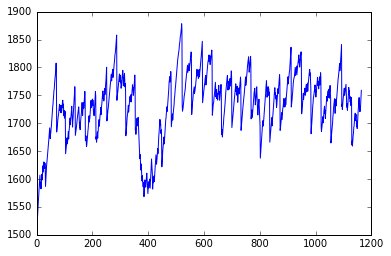

In [2]:
dataset = pd.read_csv('duke_test20.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

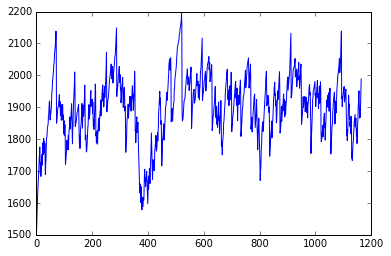

In [3]:
dataset1 = pd.read_csv('duke_test64.csv', usecols=[1], engine='python')
plt.plot(dataset1)
plt.show()

dataset2 = pd.read_csv('NorthCarolinaELO.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset2)
plt.show()

# Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have **memory blocks** that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the **sigmoid activation** units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

***NOTE***: **CAN OTHER ACTIVATION FUNCTION BE USED OTHER THAN SIGMOID**?

There are three types of gates within a unit:
- **Forget Gate**: conditionally decides what information to throw away from the block.
- **Input Gate**: conditionally decides which values from the input to update the memory state.
- **Output Gate**: conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

## LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

**X(t) -> Y(t+1)**

**In our case, ELO(t) -> ELO(t+1)**

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

Before we get started, let’s first import all of the functions and classes we intend to use. This assumes a working SciPy environment with the Keras deep learning library installed.

**We can try to compare the results from LSTM to other Time Series Analysis model (i.e. *ARIMA*)?**

In [4]:
import numpy as np
#import matplotlib.pyplot as plt
#import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler #MinMax used here, can we use ZScore instead?
from sklearn.metrics import mean_squared_error # For evaluating regression results, can we use other metrics?

Using TensorFlow backend.


In [5]:
# fix random seed for reproducibility
np.random.seed(123)

In [6]:
# load the dataset
dataframe = pd.read_csv('duke_test20.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [7]:
dataframe.head()

,ELO
0,1500.000000
1,1510.000000
2,1519.712256
3,1529.440826
4,1539.169402


We can load this dataset easily using the Pandas library. We are not interested in the date, given that each observation is separated by the same interval of one month. Therefore, when we load the dataset we can exclude the first column.

LSTMs are **sensitive to the scale of the input data**, specifically when the **sigmoid (default) or tanh** activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called **normalizing**. We can easily normalize the dataset using the **MinMaxScaler** preprocessing class from the scikit-learn library.

***NOTE***: CAN WE USE OTHER NORMALIZATION FUNCTION (i.e. Z-Score)?

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
dataset[0:5]

array([[ 0.        ],
       [ 0.02643895],
       [ 0.05211735],
       [ 0.07783842],
       [ 0.10355997]], dtype=float32)

For a normal classification or regression problem, we would do this using **cross validation**.

With time series data, the **sequence** of values is important. 

A simple method that we can use is to split the ordered dataset into train and test datasets. 

The code below calculates the index of the split point and separates the data into the training datasets with 80% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.8) # Get the cut-off point for training set
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

929 233


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the **dataset**, which is a NumPy array that we want to convert into a dataset, and the **look_back**, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1): # Since we have a much larger dataset, tweaking the step might make sense
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Let’s use this function to prepare the train and test datasets for modeling.

In [12]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
testX[0:5]

array([[ 0.76538515],
       [ 0.77738237],
       [ 0.78629494],
       [ 0.79923248],
       [ 0.75785446]], dtype=float32)

In [14]:
trainX[0:5]

array([[ 0.        ],
       [ 0.02643895],
       [ 0.05211735],
       [ 0.07783842],
       [ 0.10355997]], dtype=float32)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [15]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [16]:
#look_back=1
# create and fit the LSTM network
model = Sequential()
# Original code setting 4 LSTM blocks, however, it throw an error as below
#### Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (94, 1)
#model.add(LSTM(32, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(32, input_shape=(1, look_back)))
## Stacking LSTM layers does not work for now
## expected dense_3 to have shape (None, 1) but got array with shape (1, 917)
#model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
4s - loss: 0.0277
Epoch 2/100
3s - loss: 0.0030
Epoch 3/100
3s - loss: 0.0021
Epoch 4/100
4s - loss: 0.0021
Epoch 5/100
4s - loss: 0.0021
Epoch 6/100
4s - loss: 0.0021
Epoch 7/100
4s - loss: 0.0021
Epoch 8/100
4s - loss: 0.0020
Epoch 9/100
4s - loss: 0.0020
Epoch 10/100
4s - loss: 0.0020
Epoch 11/100
4s - loss: 0.0021
Epoch 12/100
4s - loss: 0.0020
Epoch 13/100
4s - loss: 0.0021
Epoch 14/100
4s - loss: 0.0021
Epoch 15/100
4s - loss: 0.0020
Epoch 16/100
4s - loss: 0.0021
Epoch 17/100
4s - loss: 0.0021
Epoch 18/100
4s - loss: 0.0020
Epoch 19/100
4s - loss: 0.0020
Epoch 20/100
4s - loss: 0.0020
Epoch 21/100
4s - loss: 0.0020
Epoch 22/100
4s - loss: 0.0020
Epoch 23/100
4s - loss: 0.0020
Epoch 24/100
4s - loss: 0.0020
Epoch 25/100
4s - loss: 0.0020
Epoch 26/100
4s - loss: 0.0020
Epoch 27/100
4s - loss: 0.0020
Epoch 28/100
4s - loss: 0.0020
Epoch 29/100
4s - loss: 0.0020
Epoch 30/100
4s - loss: 0.0019
Epoch 31/100
4s - loss: 0.0020
Epoch 32/100
4s - loss: 0.0020
Epoch 33/100
4s -

In [17]:
# Look at model (graph)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.18 RMSE
Test Score: 16.20 RMSE


**Interpreting the results:**

We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset, and about 52 passengers (in thousands) on the test dataset.

Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [19]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

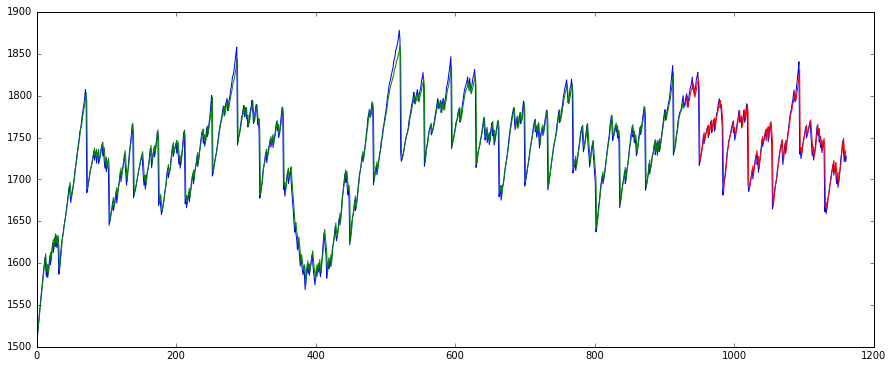

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## LSTM for Regression Using the Window Method

We can also phrase the problem so that multiple, recent time steps (*multiple*) can be used to make the prediction for the next time step.

This is called a **window**, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence **(t+1)**, we can use the current time (t), as well as the **two prior times (t-1 and t-2)** as input variables.

***When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.***

The **create_dataset()** function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

In [21]:
# reshape into X=t-2, t-1, t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [22]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
4s - loss: 0.0146
Epoch 2/100
3s - loss: 0.0030
Epoch 3/100
4s - loss: 0.0029
Epoch 4/100
4s - loss: 0.0027
Epoch 5/100
4s - loss: 0.0027
Epoch 6/100
4s - loss: 0.0025
Epoch 7/100
4s - loss: 0.0024
Epoch 8/100
4s - loss: 0.0024
Epoch 9/100
4s - loss: 0.0022
Epoch 10/100
4s - loss: 0.0022
Epoch 11/100
4s - loss: 0.0022
Epoch 12/100
4s - loss: 0.0021
Epoch 13/100
4s - loss: 0.0022
Epoch 14/100
4s - loss: 0.0021
Epoch 15/100
4s - loss: 0.0022
Epoch 16/100
4s - loss: 0.0021
Epoch 17/100
4s - loss: 0.0021
Epoch 18/100
5s - loss: 0.0021
Epoch 19/100
5s - loss: 0.0021
Epoch 20/100
5s - loss: 0.0020
Epoch 21/100
7s - loss: 0.0020
Epoch 22/100
6s - loss: 0.0021
Epoch 23/100
5s - loss: 0.0020
Epoch 24/100
4s - loss: 0.0021
Epoch 25/100
4s - loss: 0.0021
Epoch 26/100
4s - loss: 0.0020
Epoch 27/100
4s - loss: 0.0021
Epoch 28/100
4s - loss: 0.0020
Epoch 29/100
4s - loss: 0.0020
Epoch 30/100
5s - loss: 0.0020
Epoch 31/100
4s - loss: 0.0021
Epoch 32/100
4s - loss: 0.0020
Epoch 33/100
5s -

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [25]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [26]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 17.13 RMSE
Test Score: 17.49 RMSE


**Interpreting the results:**

We can see that the model has an average error of about 26 passengers (in thousands) on the training dataset, and about 64 passengers (in thousands) on the test dataset.

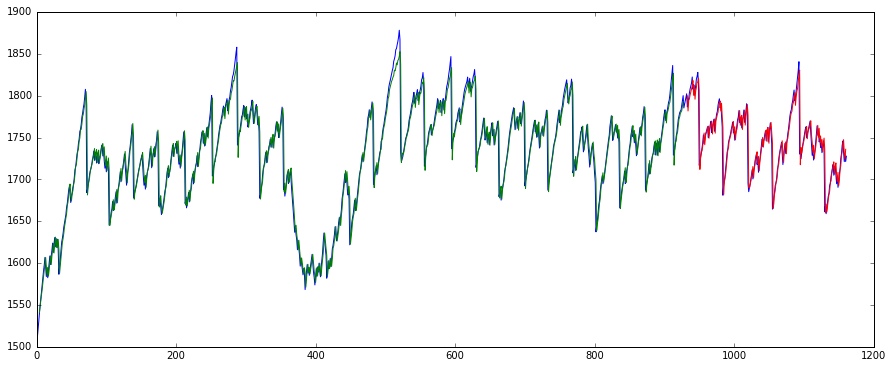

In [38]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## LSTM for Regression with Time Steps

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1. 

In [44]:
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [52]:
# create and fit the LSTM network
#batch_size=1
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

ValueError: Error when checking target: expected dense_11 to have shape (1, 1) but got array with shape (1, 925)

In [46]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.52 RMSE
Test Score: 17.28 RMSE


**Interpreting the results:**

We can see that the model has an average error of about 27 passengers (in thousands) on the training dataset, and about 61 passengers (in thousands) on the test dataset.

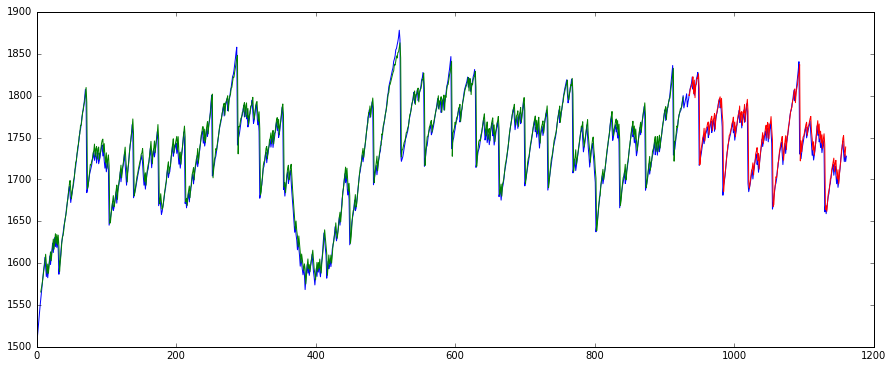

In [47]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## LSTM with Memory Between Batches

The LSTM network has memory, which is capable of *remembering across long sequences*.

Normally, the state within the network is **reset** after each training batch when fitting the model, as well as each call to **model.predict()** or **model.evaluate()**.

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer **“stateful”**. This means that it can build **state** over the entire training sequence and even *maintain* that state if needed to make predictions.

It requires that the training data **not be shuffled** when fitting the network. It also requires **explicit resetting** of the network state after each **exposure** to the training data (epoch) by calls to **model.reset_states()**. This means that we must create our own outer loop of epochs and within each epoch call **model.fit()** and **model.reset_states()**.

In [48]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(123)
# load the dataset
dataframe = pd.read_csv('duke_test20.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/1
6s - loss: 0.0071
Epoch 1/1
5s - loss: 0.0055
Epoch 1/1
5s - loss: 0.0049
Epoch 1/1
5s - loss: 0.0042
Epoch 1/1
6s - loss: 0.0034
Epoch 1/1
6s - loss: 0.0028
Epoch 1/1
6s - loss: 0.0024
Epoch 1/1
6s - loss: 0.0022
Epoch 1/1
6s - loss: 0.0022
Epoch 1/1
6s - loss: 0.0021
Epoch 1/1
6s - loss: 0.0021
Epoch 1/1
6s - loss: 0.0021
Epoch 1/1
7s - loss: 0.0021
Epoch 1/1
7s - loss: 0.0021
Epoch 1/1
7s - loss: 0.0021
Epoch 1/1
7s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
7s - loss: 0.0020
Epoch 1/1
7s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
7s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
7s - loss: 0.0020
Epoch 1/1
7s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0020
Epoch 1/1
6s - loss: 0.0019
Epoch 1/1
6s - loss:

**Interpreting the results:**

We can see that the model has an average error of about 21 passengers (in thousands) on the training dataset, and about 52 passengers (in thousands) on the test dataset.

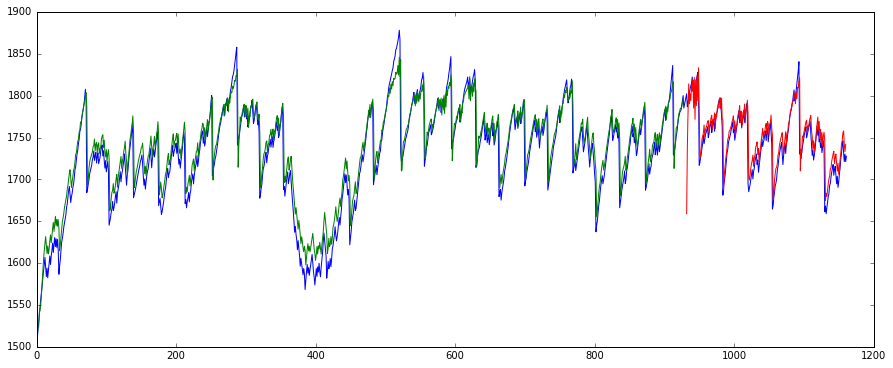

In [49]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset) # return a new array with the same structure/data type of the original
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stacked LSTMs with Memory Between Batches

LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to **True**.

In [53]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = pd.read_csv('duke_test20.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/1
13s - loss: 0.0116
Epoch 1/1
10s - loss: 0.0106
Epoch 1/1
10s - loss: 0.0094
Epoch 1/1
10s - loss: 0.0072
Epoch 1/1
10s - loss: 0.0047
Epoch 1/1
11s - loss: 0.0030
Epoch 1/1
11s - loss: 0.0024
Epoch 1/1
11s - loss: 0.0025
Epoch 1/1
11s - loss: 0.0024
Epoch 1/1
11s - loss: 0.0023
Epoch 1/1
11s - loss: 0.0023
Epoch 1/1
12s - loss: 0.0023
Epoch 1/1
12s - loss: 0.0023
Epoch 1/1
12s - loss: 0.0024
Epoch 1/1
12s - loss: 0.0024
Epoch 1/1
13s - loss: 0.0025
Epoch 1/1
13s - loss: 0.0026
Epoch 1/1
13s - loss: 0.0027
Epoch 1/1
13s - loss: 0.0026
Epoch 1/1
13s - loss: 0.0026
Epoch 1/1
14s - loss: 0.0026
Epoch 1/1
15s - loss: 0.0025
Epoch 1/1
15s - loss: 0.0025
Epoch 1/1
13s - loss: 0.0025
Epoch 1/1
14s - loss: 0.0024
Epoch 1/1
12s - loss: 0.0023
Epoch 1/1
13s - loss: 0.0022
Epoch 1/1
12s - loss: 0.0022
Epoch 1/1
12s - loss: 0.0021
Epoch 1/1
12s - loss: 0.0020
Epoch 1/1
12s - loss: 0.0020
Epoch 1/1
12s - loss: 0.0020
Epoch 1/1
12s - loss: 0.0020
Epoch 1/1
15s - loss: 0.0021
Epoch 1/1
14s 

**Interpreting the results:**

We can see that the model has an average error of about 20 passengers (in thousands) on the training dataset, and about 56 passengers (in thousands) on the test dataset.

**MORE EPOCHS MIGHT HELP HERE!!**

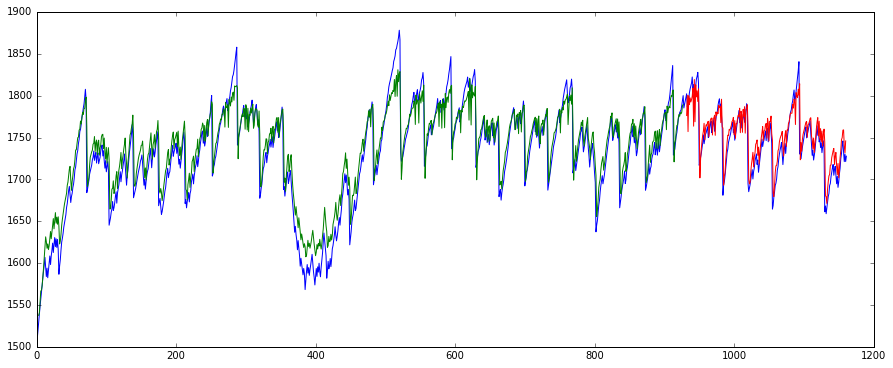

In [54]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**SUMMARY:**
I believe we should use these models, in comparison to ARIMA models, to illustrate the benefit of LSTM.

# Bi-directional LSTM

If we work under the assumption that each game is independent from each other, then we are not leaking future information into current forecasting by reverse the sequence. Also, bi-directional model would provide more contextual information about the inner seasonalities and invariant/autocorrelated patterns in RNN.

## Bi-directional LSTM in Keras
Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper.

This wrapper takes a recurrent layer (e.g. the first LSTM layer) as an argument.

It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The options are:

- ‘sum‘: The outputs are added together.
- ‘mul‘: The outputs are multiplied together.
- ‘concat‘: The outputs are concatenated together (the default), providing double the number of outputs to the next layer.
- ‘ave‘: The average of the outputs is taken.

The default mode is to **concatenate**, and this is the method often used in studies of bidirectional LSTMs.